In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
def process_patch(pixels: np.ndarray, beta: float):
    x = pixels.astype(np.float32)
    mu = x.mean()
    s = (x - mu).ravel()
    w = np.abs(s) / np.sum(np.abs(s) + 1e-12)
    neff = 1./np.sum(w ** 2 + 1e-12)
    
    r_neff = int(np.floor(beta * neff))
    r_neff = max(1, min(r_neff, len(w)))
    
    if r_neff < s.size:
        idx = np.argpartition(np.abs(s), -r_neff)[-r_neff:]
        y = np.zeros_like(w)
        y[idx] = s[idx]
    elif r_neff == s.size:
        y = s.copy()
    else:
        y = np.zeros_like(w)

    processed = y.reshape(x.shape) + mu
    return processed, r_neff

In [11]:
def process_pixel(pixels: np.ndarray, beta: float):
    x = pixels.astype(np.float32)
    mu = x.mean()
    s = (x - mu).ravel()
    w = np.abs(s) / np.sum(np.abs(s) + 1e-12)
    neff = 1./np.sum(w ** 2 + 1e-12)
    
    r_neff = int(np.floor(beta * neff))
    r_neff = max(1, min(r_neff, len(w)))
    print(r_neff)
    
    if r_neff < s.size:
        idx = np.argpartition(np.abs(s), -r_neff)[-r_neff:]
        y = np.zeros_like(w)
        y[idx] = s[idx]
    else:
        y = s.copy()

    processed = y.reshape(x.shape) + mu
    return processed, r_neff

In [12]:
def EMP_pixel(image, beta:float):
    
    if isinstance(image, str):
        img = Image.open(image)
        arr = np.array(img)
    else:
        arr = np.array(image)
        
    h, w, c = arr.shape
    total = h * w * c
    
    r = arr[:, :, 0]
    g = arr[:, :, 1]
    b = arr[:, :, 2]
    
    r_pros, nr = process_pixel(r, beta=beta)
    g_pros, ng = process_pixel(g, beta=beta)
    b_pros, nb = process_pixel(b, beta=beta)
    
    out = np.stack([r_pros, g_pros, b_pros], axis=2)
    sparsity = 1- (nr + ng + nb)/total
    return np.clip(out, 0, 255).astype(np.uint8), sparsity

def EMP_patch(image, beta: float, patch_size: int = 4):

    if isinstance(image, str):
        img = Image.open(image)
        arr = np.array(img)
    else:
        arr = np.array(image)
        
    h, w, c = arr.shape
    total = h * w * c
    
    out = np.zeros_like(arr)
    pk = 0
    for ch in range(c):
        channel = arr[:, :, ch]
        channel_out = np.zeros_like(channel)

        for i in range(0, h, patch_size):
            for j in range(0, w, patch_size):
                i_end = min(i + patch_size, h)
                j_end = min(j + patch_size, w)
                patch = channel[i:i_end, j:j_end]
                patch_proc, pkk = process_patch(patch, beta=beta)
                channel_out[i:i_end, j:j_end] = patch_proc
                pk += pkk
        out[:, :, ch] = channel_out
    
    sparsity = 1 - pk/total
    return np.clip(out, 0, 255).astype(np.uint8), sparsity
    

In [5]:
def calculate_metrics(original, processed):
    original = np.clip(original, 0, 255).astype(np.uint8)
    processed = np.clip(processed, 0, 255).astype(np.uint8)
    psnr_value = psnr(original, processed, data_range=255)
    if original.ndim == 3:
        ssim_value = ssim(original, processed, channel_axis=2, data_range=255)
    else:
        ssim_value = ssim(original, processed, data_range=255)
    return {'psnr': psnr_value, 'ssim': ssim_value}


def EMP_pruning(
    image_path,
    save_path=None,
    pixel_beta: float = 1.0,
    patch_beta: float = 1.0,
    patch_size: int = 4,
    dpi: int = 150
):
    if isinstance(image_path, str):
        img = Image.open(image_path)
        name = Path(image_path).stem
        original = np.array(img)
    else:
        name = "image"
        original = np.array(image_path)
    
    pix_img, pix_sparsity = EMP_pixel(image_path, pixel_beta)
    pix_metrics = calculate_metrics(original, pix_img)
    
    patch_img, patch_sparsity = EMP_patch(image_path, patch_beta, patch_size)
    patch_metrics = calculate_metrics(original, patch_img)

    # ----- Plot 1×3
    plt.figure(figsize=(18, 6))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(original.astype(np.uint8))
    ax1.set_title('Original', fontsize=14, fontweight='bold')
    ax1.axis('off')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(pix_img)
    ax2.set_title(
        f'EMP Pixel-wise\nPSNR: {pix_metrics["psnr"]:.1f} dB'
        f'\nSSIM: {pix_metrics["ssim"]:.3f}'
        f'\nSparsity: {pix_sparsity:.3f}',
        fontsize=12
    )
    ax2.axis('off')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(patch_img)
    ax3.set_title(
        f'EMP Patch-wise\nPSNR: {patch_metrics["psnr"]:.1f} dB'
        f'\nSSIM: {patch_metrics["ssim"]:.3f}'
        f'\nSparsity: {patch_sparsity:.3f}',
        fontsize=12
    )
    ax3.axis('off')

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(Path(save_path).parent, exist_ok=True)
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    plt.show()

    return {
        'pixel': {
            'image': pix_img,
            'metrics': pix_metrics,
            'sparsity': pix_sparsity,
        },
        'patch_rgb': {
            'image': patch_img,
            'metrics': patch_metrics,
            'sparsity': patch_sparsity,
        }
    }


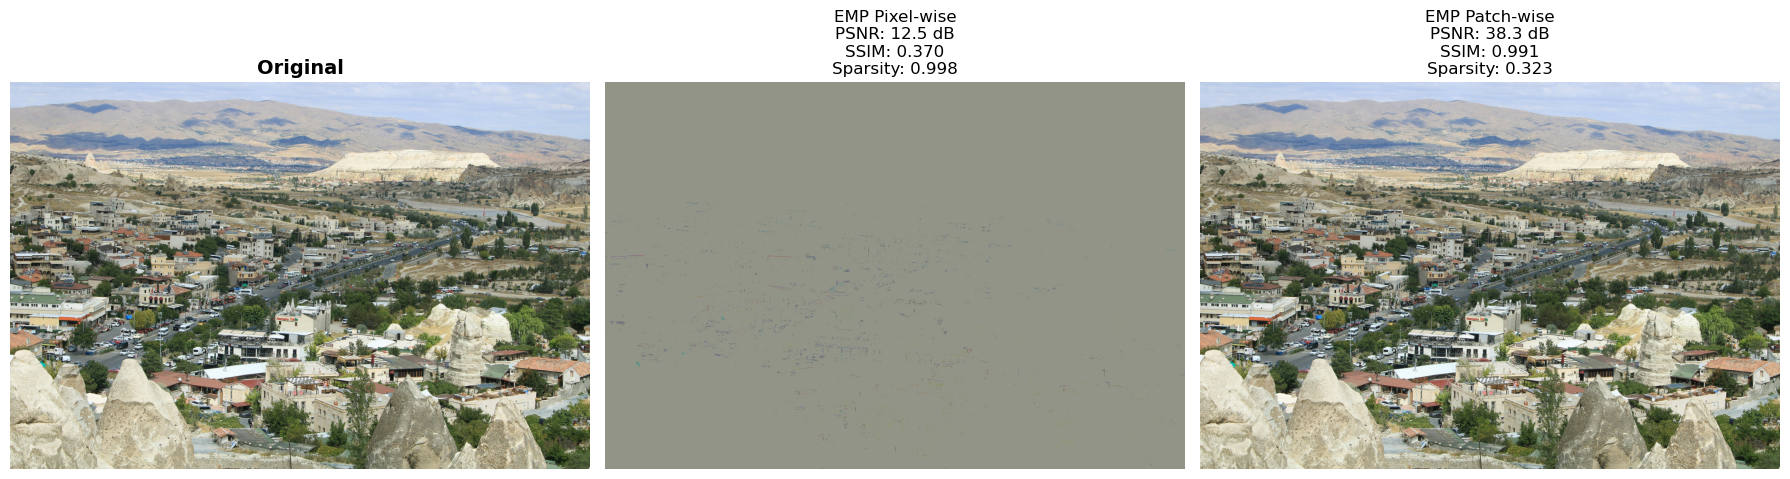

{'pixel': {'image': array([[[146, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [146, 148, 135],
          [146, 148, 135],
          [146, 148, 135]],
  
         [[146, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [146, 148, 135],
          [146, 148, 135],
          [146, 148, 135]],
  
         [[146, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [146, 148, 135],
          [146, 148, 135],
          [146, 148, 135]],
  
         ...,
  
         [[146, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [146, 148, 135],
          [146, 148, 135],
          [146, 148, 135]],
  
         [[146, 148, 135],
          [146, 148, 135],
          [146, 148, 135],
          ...,
          [146, 148, 135],
          [146, 148, 135],
          [146, 148, 135]],
  
         [[146, 148, 135],
          [146, 148, 135],
      

In [6]:
EMP_pruning('figures/city.jpg', 'figures/result_city.png', 1, 1, 4, 150)

In [13]:
EMP_pixel('figures/city.jpg', 1)

41568
41567
41568


(array([[[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
         [146, 148, 135],
         [146, 148, 135]],
 
        [[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
         [146, 148, 135],
         [146, 148, 135]],
 
        [[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
         [146, 148, 135],
         [146, 148, 135]],
 
        ...,
 
        [[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
         [146, 148, 135],
         [146, 148, 135]],
 
        [[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
         [146, 148, 135],
         [146, 148, 135]],
 
        [[146, 148, 135],
         [146, 148, 135],
         [146, 148, 135],
         ...,
         [146, 148, 135],
  